In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 4.9 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633961 sha256=d4bba742cf5fffc681828e51c04f6e87aea490b4bbf9873d47cfbcf087912198
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise.model_selection.split import train_test_split
from surprise.model_selection import cross_validate, GridSearchCV
import pandas as pd
import numpy as np
import os, io
from surprise import KNNBasic, KNNWithMeans
from surprise import SVDpp
from surprise import SVD
from surprise import accuracy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
twitch = pd.read_csv('/content/drive/MyDrive/twitch256/train_streamID_new.csv')
twitch.head()

,UserID,StreamID,Rating
0,1,33846768288,4.600000
1,1,33886469056,1.000000
2,1,33887624992,2.874988
3,1,33890145056,4.600000
4,1,33903958784,4.600000


In [ ]:
twitch.shape

(3051732, 3)



---



---



In [ ]:
reader = Reader(rating_scale=(1,10))  #invoke reader instance of surprise library
data=Dataset.load_from_df(twitch,reader) #load dataset into Surprise datastructure Dataset
trainingSet, testSet = train_test_split(data, test_size=0.2, train_size=None, random_state=42, shuffle=True)

In [ ]:
acc=[]
reg_array=[]
factor=[]
n_f=[1,5,10]
reg=0
for i in range(0,3):
  f=n_f[i]
  reg=0
  for j in range(25):
    reg+=0.02
    algo = SVD(n_factors=f, reg_all=reg) #at the very least, set number of factors and regularization parameter
    algo.fit(trainingSet)
    predictions_svd = algo.test(testSet)
    acc.append(accuracy.rmse(predictions_svd, verbose=True) )
    factor.append(f)
    reg_array.append(reg)
    print(f'{f},{reg}')

In [ ]:
performance = pd.DataFrame(data={'n_factors':factor,'reg':reg_array,'RMSE':acc})
performance.head()

,n_factors,reg,RMSE
0,1,0.02,2.949701
1,1,0.04,2.944532
2,1,0.06,2.942421
3,1,0.08,2.938455
4,1,0.10,2.936013


In [ ]:
performance.loc[performance['RMSE']==performance['RMSE'].min()]

,n_factors,reg,RMSE
8,1,0.18,2.93039


Text(0, 0.5, 'rmse')

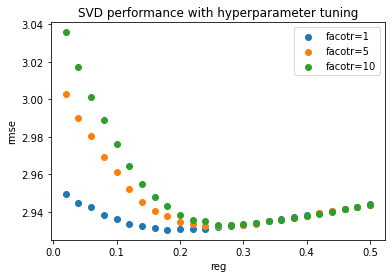

In [ ]:
from matplotlib import pyplot as plt

x_1=performance['reg'].loc[performance['n_factors']==1]
x_2=performance['reg'].loc[performance['n_factors']==5]
x_3=performance['reg'].loc[performance['n_factors']==10]

y_1=performance['RMSE'].loc[performance['n_factors']==1]
y_2=performance['RMSE'].loc[performance['n_factors']==5]
y_3=performance['RMSE'].loc[performance['n_factors']==10]

plt.scatter(x_1,y_1)
plt.scatter(x_2,y_2)
plt.scatter(x_3,y_3)

plt.title('SVD performance with hyperparameter tuning')
plt.legend(['facotr=1','facotr=5','facotr=10'])
plt.xlabel('reg')
plt.ylabel('rmse')

In [ ]:
algo = SVD(n_factors=1, reg_all=0.18) #at the very least, set number of factors and regularization parameter
algo.fit(trainingSet)
predictions_svd = algo.test(testSet)

In [ ]:
twitch.head()

,UserID,StreamID,Rating
0,1,33846768288,2.014098
1,1,33887624992,1.000000
2,1,33890145056,2.014098
3,1,33903958784,2.014098
4,1,33929318864,9.993371


In [ ]:
# Find how much average of overpredict and underpredict when using the model
underpredict_diff=[] # the difference of predict and orignal
overpredict_diff=[]
overpredict_stream=[] # the streamID that are over or under
underpredict_stream=[]

for i in range(len(testSet)):
  pred=algo.predict(testSet[i][0],testSet[i][1])[3]
  orign = testSet[i][2]
  if pred-orign>0: # when overpredict the rating
    overpredict_diff.append(pred-orign)
    overpredict_stream.append(testSet[i][1])
  elif pred-orign<0: # when underpredict the rating
    underpredict_diff.append(pred-orign)
    underpredict_stream.append(testSet[i][1])

In [ ]:
underData ={'streamid':underpredict_stream,'diff':underpredict_diff}
df_under=pd.DataFrame(underData)

In [ ]:
overData ={'streamid':overpredict_stream,'diff':overpredict_diff}
df_over = pd.DataFrame(overData)

In [ ]:
df_over['filter_diff']=df_over.groupby(['streamid'])['diff'].transform('mean') # use the mean if the stream is repeatedly recorded
df_under['filter_diff']=df_under.groupby(['streamid'])['diff'].transform('mean')

In [ ]:
df_over.drop(['diff'],axis=1,inplace=True)
df_under.drop(['diff'],axis=1,inplace=True)

ave_under=df_under['filter_diff'].mean() # this difference will be scale based on pagerank's popularity
ave_over = df_over['filter_diff'].mean()

print(f'When model overpredict, it create {ave_over} difference')
print(f'When mode underpredict, it create {ave_under} difference')

When model overpredict, it create 1.9021433927814264 difference
When mode underpredict, it create -3.2250894353974684 difference


In [ ]:
# create test data to that move to PageRank bias tuning
testdf=pd.DataFrame(testSet,columns=['userid','streamid','rating']) 
testdf['pred'] = pred
testdf.head()

,userid,streamid,rating,pred
0,34188,34317372320,1.0,2.804544
1,31944,34045132400,1.0,2.804544
2,45566,34350806944,1.0,2.804544
3,72160,33963008000,10.0,2.804544
4,22244,34127594752,10.0,2.804544


In [ ]:
testdf.to_csv('/content/drive/MyDrive/twitch256/test_streamID_full.csv',index=None)
df_under.to_csv('/content/drive/MyDrive/twitch256/underDiff_full.csv',index=None)
df_over.to_csv('/content/drive/MyDrive/twitch256/overDiff_full.csv',index=None)



---



---

